<a href="https://colab.research.google.com/github/ajag408/DeepGenerativeMusic/blob/main/RNNBaseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!sudo apt install -y fluidsynth

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fluidsynth is already the newest version (1.1.9-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [2]:
!pip install --upgrade pyfluidsynth

In [3]:
!pip install pretty_midi

In [4]:
#install basic libraries
import collections
import datetime
import fluidsynth
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple
tf.random.set_seed(42)
np.random.seed(42)

In [12]:
#Get dataset Maestro-v2.0.0-midi
tf.keras.utils.get_file(
  'maestro-v2.0.0-midi.zip',
  origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
  extract=True,
  cache_dir='.', cache_subdir='data',
)

59252736/59243107 [==============================] - 1s 0us/step


'./data/maestro-v2.0.0-midi.zip'

In [13]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1282


In [14]:
import pathlib
import glob
sample_file = glob.glob(str(pathlib.Path('data/maestro-v2.0.0')/'**/*.mid*'))[1]
print(sample_file)

data/maestro-v2.0.0/2013/ORIG-MIDI_01_7_8_13_Group__MID--AUDIO_07_R2_2013_wav--1.midi


In [15]:
import pretty_midi
file = pretty_midi.PrettyMIDI(sample_file)

In [16]:
waveform = file.fluidsynth(fs=16000)
waveform_short = waveform[:30*16000]
display.Audio(waveform_short, rate=16000)

AttributeError: ignored

In [ ]:
print('Number of instruments:', len(file.instruments))
print('Instrument name:', pretty_midi.program_to_instrument_name(file.instruments[0].program))

Number of instruments: 1
Instrument name: Acoustic Grand Piano


In [ ]:
instrument = file.instruments[0]
for i, note in enumerate(instrument.notes[:15]):
  print(f'{i}: pitch={note.pitch}, note_name={pretty_midi.note_number_to_name(note.pitch)},'
        f' duration={note.end - note.start:.4f}')

0: pitch=31, note_name=G1, duration=6.6107
1: pitch=43, note_name=G2, duration=6.6536
2: pitch=67, note_name=G4, duration=6.8594
3: pitch=79, note_name=G5, duration=6.9688
4: pitch=71, note_name=B4, duration=0.5964
5: pitch=72, note_name=C5, duration=0.1628
6: pitch=74, note_name=D5, duration=0.3490
7: pitch=74, note_name=D5, duration=0.3581
8: pitch=74, note_name=D5, duration=0.3971
9: pitch=72, note_name=C5, duration=0.6159
10: pitch=74, note_name=D5, duration=0.1927
11: pitch=75, note_name=D#5, duration=1.3177
12: pitch=74, note_name=D5, duration=0.4727
13: pitch=72, note_name=C5, duration=0.3125
14: pitch=74, note_name=D5, duration=0.5833


In [ ]:
def midi_to_df(files: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(files)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [ ]:
music_df = midi_to_df(sample_file)
music_df.head(10)

,pitch,start,end,step,duration
0,79,1.000000,7.968750,0.000000,6.968750
1,67,1.001302,7.860677,0.001302,6.859375
2,43,1.007812,7.661458,0.006510,6.653646
3,31,1.009115,7.619792,0.001302,6.610677
4,71,10.300781,10.897135,9.291667,0.596354
5,72,10.837240,11.000000,0.536458,0.162760
6,74,11.007812,11.356771,0.170573,0.348958
7,74,11.716146,12.074219,0.708333,0.358073
8,74,12.407552,12.804688,0.691406,0.397135
9,72,13.138021,13.753906,0.730469,0.615885


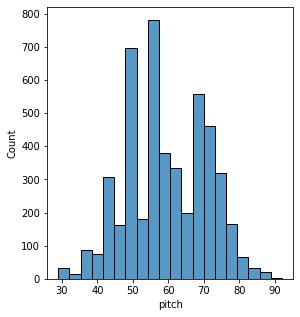

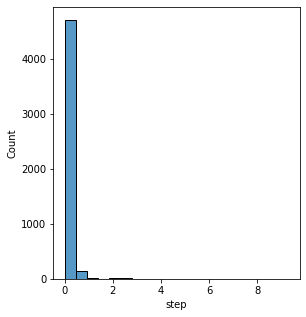

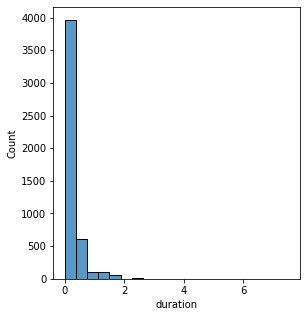

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=[15, 5])
plt.subplot(1, 3, 1)
sns.histplot(music_df, x="pitch", bins=20)

plt.figure(figsize=[15, 5])
plt.subplot(1, 3, 1)
sns.histplot(music_df, x="step", bins=20)

plt.figure(figsize=[15, 5])
plt.subplot(1, 3, 1)
sns.histplot(music_df, x="duration", bins=20)

In [ ]:
all_notes = []
for f in filenames[:5]:
  notes = midi_to_df(f)
  all_notes.append(notes)

notes_df = pd.concat(all_notes)

Number of notes parsed: 47782


In [ ]:
notes_df.head(10)

,pitch,start,end,step,duration
0,68,0.964844,1.709635,0.000000,0.744792
1,73,0.983073,1.677083,0.018229,0.694010
2,64,0.998698,1.535156,0.015625,0.536458
3,61,1.006510,1.893229,0.007812,0.886719
4,44,1.061198,5.024740,0.054688,3.963542
5,37,1.098958,2.503906,0.037760,1.404948
6,64,2.411458,2.954427,1.312500,0.542969
7,68,2.415365,3.544271,0.003906,1.128906
8,61,2.428385,2.973958,0.013021,0.545573
9,56,2.460938,2.656250,0.032552,0.195312


In [ ]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([notes_df[key] for key in key_order], axis=1)

In [ ]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec


TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [ ]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)
  
  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'duration': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [ ]:
batch_size = 64
buffer_size = len(notes_df) - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
def mse(y_true: tf.Tensor, y_pred: tf.Tensor):
  mser = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mser + positive_pressure)

In [ ]:
inputs = tf.keras.Input((seq_length, 3))
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse,
      'duration': mse,
}


model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.5))

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25, 3)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 128)          67584       ['input_1[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm[0][0]']                   
                                                                                                  
 pitch (Dense)                  (None, 128)          16512       ['lstm[0][0]']                   
                                                                                              

In [ ]:
print(model.evaluate(train_ds, return_dict=True))

746/746 [==============================] - 25s 22ms/step - loss: 5.2844 - duration_loss: 0.3122 - pitch_loss: 4.8581 - step_loss: 0.1141
{'loss': 5.284391403198242, 'duration_loss': 0.312198668718338, 'pitch_loss': 4.858060836791992, 'step_loss': 0.11412899196147919}


In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [ ]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=50,
    callbacks=callbacks,
)

Epoch 1/50
746/746 [==============================] - 34s 42ms/step - loss: 72.4443 - duration_loss: 11.5153 - pitch_loss: 51.4145 - step_loss: 9.5146
Epoch 2/50
746/746 [==============================] - 30s 41ms/step - loss: 66.0849 - duration_loss: 8.7386 - pitch_loss: 48.0693 - step_loss: 9.2770
Epoch 3/50
746/746 [==============================] - 30s 41ms/step - loss: 65.5080 - duration_loss: 9.0851 - pitch_loss: 47.1186 - step_loss: 9.3042
Epoch 4/50
746/746 [==============================] - 31s 41ms/step - loss: 68.4119 - duration_loss: 9.1399 - pitch_loss: 49.9589 - step_loss: 9.3131
Epoch 5/50
746/746 [==============================] - 31s 42ms/step - loss: 67.8416 - duration_loss: 9.1646 - pitch_loss: 49.3729 - step_loss: 9.3041
Epoch 6/50
746/746 [==============================] - 32s 43ms/step - loss: 67.4325 - duration_loss: 9.1688 - pitch_loss: 48.9242 - step_loss: 9.3396
Epoch 7/50
746/746 [==============================] - 32s 43ms/step - loss: 65.8352 - duration_loss

In [ ]:
def predict_next_note(notes: np.ndarray, keras_model: tf.keras.Model, temperature: float = 1.0) -> int:
  
  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']
 
  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [ ]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([music_df[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

In [ ]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,67,2.890824,3.602288,2.890824,6.493112
1,68,4.570398,1.019113,7.461222,8.480335
2,60,5.178192,0.436264,12.639414,13.075678
3,68,5.289979,0.359707,17.929394,18.289101
4,68,5.284190,0.334628,23.213583,23.548211
5,68,5.285931,0.332958,28.499514,28.832473
6,60,5.286167,0.332732,33.785681,34.118413
7,60,5.302938,0.344181,39.088619,39.432800
8,68,5.305732,0.346089,44.394351,44.740440
9,60,5.286205,0.332698,49.680556,50.013254


In [ ]:
def df_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  file = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  file.instruments.append(instrument)
  file.write(out_file)
  return file

In [ ]:
generated = df_to_midi(
    music_df, out_file='generated.midi', instrument_name=instrument_name)

In [ ]:
waveform = generated.fluidsynth(fs=16000)
waveform_short = waveform[:30*16000]
display.Audio(waveform_short, rate=16000)